In [1]:
# inspired by https://www.tensorflow.org/alpha/tutorials/generative/pix2pix

In [2]:
import tensorflow as tf
tf.enable_eager_execution()

In [3]:
from tensorflow.python import roll as _roll
from tensorflow.python.framework import ops
import numpy as np
from astropy.io import fits
import os
import time
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import clear_output
from io import BytesIO

In [4]:
%matplotlib inline

In [5]:
PATH = Path("/scratch/datasets/astro_deconv_2019_split/")
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_SIZE = 256
OUTPUT_CHANNELS = 1
LAMBDA = 100
EPOCHS = 200

In [6]:
def myFs(img):
    axes = tuple(range(img.ndim))
    shift = [dim // 2 for dim in img.shape]
    return _roll(img, shift, axes)

def myiFs(img):
    axes = tuple(range(img.ndim))
    shift = [-(int(dim) // 2) for dim in img.shape]
    return _roll(img, shift, axes)

In [7]:
def landman_convolve(arr1, arr2):
    """
    If unequal size arr2 should be the bigger one
    """
    # dim 2> probably crashes kernel
    assert(arr1.ndim == 2)
    assert(arr2.ndim == 2)
    assert arr1.shape == (256, 256)
    assert arr2.shape == (256, 256)
    arr1hat = tf.signal.rfft2d(myiFs(tf.squeeze(arr1)))
    arr2hat = tf.signal.rfft2d(myiFs(tf.squeeze(arr2)))
    return myFs(tf.signal.irfft2d(tf.multiply(arr1hat, arr2hat)))

In [8]:
def landman_convolve_bigpsf(arr1, big_psf):
    assert arr1.shape == (256, 256)
    assert big_psf.shape == (512, 512)

    #pad = tf.cast((arr2.shape[1] - arr1.shape[1]) // 2, tf.int32)
    pad = 128
    paddings = tf.constant([[pad, pad], [pad, pad]])
    arr1 = tf.pad(tf.squeeze(arr1), paddings, "CONSTANT")

    arr1hat = tf.signal.rfft2d(myiFs(tf.squeeze(arr1)))
    arr2hat = tf.signal.rfft2d(myiFs(tf.squeeze(big_psf)))

    return myFs(tf.signal.irfft2d(tf.multiply(arr1hat, arr2hat)))[pad:-pad, pad:-pad]

In [9]:
def fits_open(path):
    content = fits.open(str(path))[0].data.squeeze().astype(np.float32)
    if IMG_SIZE == 128:
        return content[IMG_SIZE//2:-(IMG_SIZE//2), IMG_SIZE//2:-(IMG_SIZE//2)]
    else:
        return content

In [10]:
def load_fits(fits_file):
    def internal(data):
        return fits.open(BytesIO(data))[0].data.squeeze().astype(np.float32)[..., np.newaxis]
    blob = tf.io.read_file(fits_file)
    return tf.py_func(internal, [blob], tf.float32)

In [11]:
def make_dataset(glob):
    ds = tf.data.Dataset.list_files(str(glob), shuffle=False)
    ds = ds.map(load_fits)
    return ds

In [12]:
def normalize(first, *others):
    """accepts a list of images, normalized to [-.8, .8] relative to the first image"""
    min_ = tf.reduce_min(first)
    max_ = tf.reduce_max(first)
    f = lambda i: ((i - min_) / ((max_ - min_)/1.6)) - 0.8
    return [min_, max_, f(first)] + list(map(f, others))

def denormalize(images, min_, max_):
    """scales image back to min_, max_ range"""
    return [((i + 0.8)/1.6 * (max_ - min_)) + min_ for i in images]

In [13]:
def random_jitter(*images):
    if (tf.random.uniform(shape=()) > tf.to_float(0.5))  is not None:
        return [tf.image.flip_left_right(i) for i in images]
    else:
        return list(images)    

In [14]:
def downsample(filters, size, apply_batchnorm=True):
    #https://stackoverflow.com/questions/37092037/tensorflow-what-does-tf-nn-separable-conv2d-do
    
    #type_ = tf.keras.layers.DepthwiseConv2D
    type_ = tf.keras.layers.Conv2D
    
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(type_(filters,
                     size,
                     strides=2,
                     padding='same',
                     kernel_initializer=initializer,
                     use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result

In [15]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
          result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result

In [16]:
def Generator():
    if IMG_SIZE == 256:
        down_stack_start = [
            downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
            downsample(128, 4), # (bs, 64, 64, 128)
        ]
    elif IMG_SIZE == 128:
        down_stack_start = [
            downsample(128, 4, apply_batchnorm=False), # (bs, 64, 64, 128)
        ]
    else:
        raise Exception

    down_stack = down_stack_start + [
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
    ]

    if IMG_SIZE == 256:        
        up_stack.append(upsample(64, 4)) # (bs, 128, 128, 128)
    elif IMG_SIZE == 128:
        # do nothing
        ...
    else:
        raise Exception
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                           strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, IMG_SIZE, IMG_SIZE, 1)

    concat = tf.keras.layers.Concatenate()

    inputs = tf.keras.layers.Input(shape=[None,None,1])
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[None, None, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[None, None, 1], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [19]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

In [20]:
def convolve(convolved, convolver):
    return landman_convolve(tf.squeeze(convolved), tf.squeeze(convolver))
    #kernel = tf.squeeze(convolver)[:, :, tf.newaxis, tf.newaxis]
    #return tf.nn.conv2d(convolved, kernel, [1, 1, 1, 1], "SAME")

In [45]:
def like_loss(predicted, target, bigpsf):
    convolved = landman_convolve_bigpsf(tf.squeeze(predicted), tf.squeeze(bigpsf))
    #return tf.reduce_sum(tf.multiply(predicted, convolved - 2 * target)) 
    return tf.reduce_sum(tf.tensordot(tf.squeeze(predicted), (tf.squeeze(convolved) - 2 * tf.squeeze(target)), axes=1) )


In [22]:
def clean_loss(predicted, target, clean_beam):
    return l1(convolve(predicted, clean_beam), convolve(target, clean_beam))

In [23]:
def render(f, a, imgdata, title):
    i = a.pcolor(imgdata, cmap='cubehelix')
    f.colorbar(i, ax=a)
    a.set_title(title)

In [24]:
def generate_images(prediction, input_, target):
    f, ((a1, a2, a3)) = plt.subplots(1, 3, figsize=(15,3))
    render(f, a1, tf.squeeze(input_), 'input_')
    render(f, a2, tf.squeeze(target), 'target')
    render(f, a3, tf.squeeze(prediction), 'prediction')
    plt.show()

In [25]:
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        predicted = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, predicted], training=True)
        gen_loss = generator_loss(disc_generated_output, predicted, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [26]:
def train_step_likelyhood(input_image, target, bigpsf):
    with tf.GradientTape() as gen_tape:
        predicted = generator(input_image, training=True)
        likelyhood_loss = like_loss(predicted, target, bigpsf) / 2e8 + 1
        l1_loss = tf.reduce_mean(tf.abs(target - predicted))
        total_loss = likelyhood_loss + l1_loss  # * LAMBDA

    print(float(likelyhood_loss), float(l1_loss))
    
    generator_gradients = gen_tape.gradient(total_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [27]:
def l1(a, b):
    return tf.math.reduce_sum(tf.math.abs(a - b))

In [28]:
scores = []
def train(train_dataset, test_dataset, epochs):
    for epoch in range(epochs):
        step = 0
        start = time.time()

        for input_, target, psf, bigpsf, clean_beam in train_dataset:
            min_, max_, input_, target, = normalize(input_, target)
            
            #train_step(input_, target)
            train_step_likelyhood(input_, target, bigpsf)
            
            step += 1

            test_interval = 100
            if (step + 1) % test_interval == 0:
                clear_output(wait=True)
                for test_input, test_target, psf, big_psf, clean_beam, wsclean in test_dataset.take(1):
                
                    r = normalize(test_input, test_target, clean_beam, wsclean)
                    min_, max_, test_input, test_target, clean_beam, wsclean = r

                    # the training=True is intentional here since
                    # we want the batch statistics while running the model
                    # on the test dataset. If we use training=False, we will get
                    # the accumulated statistics learned from the training dataset
                    # (which we don't want)
                    prediction = generator(test_input, training=True)
                    
                    likelyhood_loss = like_loss(prediction, test_target, bigpsf)
                    l1_loss = tf.reduce_mean(tf.abs(target - prediction))

                    generate_images(prediction, test_input, test_target)
                    clean_sky = convolve(target, clean_beam)
                    vacuum_l1 = l1(convolve(prediction, clean_beam), clean_sky)
                    wsclean_l1 = l1(convolve(wsclean, clean_beam),clean_sky )
                    scores.append(vacuum_l1)
                    print(f"l1 vacuum: {vacuum_l1.numpy()} wsclean: {wsclean_l1.numpy()}")

                    duration = time.time()-start
                    speed = step / duration
                    print(f"step: {step + 1} epoch: {epoch + 1} duration: {duration:.2f}s step/s: {speed:.2f}\n")
                    #for i in scores:
                    #    print(i)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

In [29]:
train_dirty_dataset = make_dataset(PATH / 'train/*-wsclean-dirty.fits')
train_skymodel_dataset = make_dataset(PATH / 'train/*-skymodel.fits')
train_psf_dataset = make_dataset(PATH / 'train/*-wsclean-psf.fits')
train_bigpsf_dataset = make_dataset(PATH / 'train/*-bigpsf-psf.fits')
train_clean_beam_dataset = make_dataset(PATH / 'train/*-clean-beam.fits')
train_dataset = tf.data.Dataset.zip((train_dirty_dataset, train_skymodel_dataset, train_psf_dataset, train_bigpsf_dataset, train_clean_beam_dataset))
train_dataset = train_dataset.map(random_jitter)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

test_dirty_dataset = make_dataset(PATH / 'test/*-wsclean-dirty.fits')
test_wsclean_dataset = make_dataset(PATH / 'test/*-wsclean-model.fits')
test_skymodel_dataset = make_dataset(PATH / 'test/*-skymodel.fits')
test_psf_dataset = make_dataset(PATH / 'test/*-wsclean-psf.fits')
test_bigpsf_dataset = make_dataset(PATH / 'test/*-bigpsf-psf.fits')
test_clean_beam_dataset = make_dataset(PATH / 'test/*-clean-beam.fits')

test_dataset = tf.data.Dataset.zip((test_dirty_dataset, test_skymodel_dataset, test_psf_dataset, test_bigpsf_dataset, test_clean_beam_dataset, test_wsclean_dataset))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(1)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.


In [30]:
generator = Generator()
discriminator = Discriminator()
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
generator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)  # 2e-4
discriminator_optimizer = tf.train.AdamOptimizer(learning_rate=2e-4, beta1=0.5)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator
                                )

# Train the shit

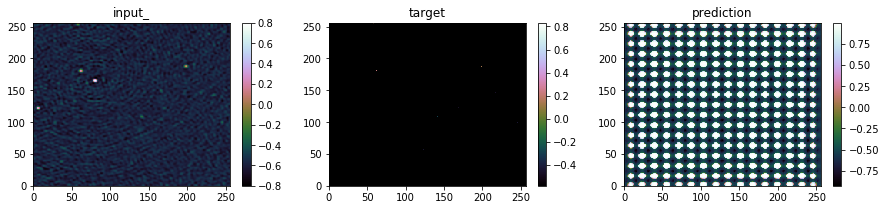

l1 vacuum: 1124399872.0 wsclean: 17380480.0
step: 200 epoch: 1 duration: 66.55s step/s: 2.99

0.7005596160888672 0.49597132205963135
0.7359928488731384 0.49153101444244385
0.7704390287399292 0.48933643102645874
0.8330123424530029 0.47838664054870605
0.871971070766449 0.473625123500824
0.7347601652145386 0.483429491519928
0.8424133658409119 0.48208630084991455
0.8519959449768066 0.46521419286727905
0.6779229640960693 0.4770216941833496
0.6847530007362366 0.4647720158100128
0.7987701892852783 0.46611499786376953
0.7379411458969116 0.4928324818611145
0.670265793800354 0.480892539024353
0.7059959173202515 0.5140931606292725
0.77110356092453 0.4843469262123108
0.7108604907989502 0.48214930295944214
0.8124534487724304 0.47390276193618774
0.8488491177558899 0.4738363027572632
0.6714369058609009 0.4629051387310028
0.6286508440971375 0.46502023935317993
0.832504391670227 0.5250487327575684
0.7801548838615417 0.4896765947341919
0.7744098901748657 0.48833680152893066
0.7794027924537659 0.47501081

In [ ]:
train(train_dataset, test_dataset, 10)

# manual trying out shit space

In [ ]:
CheckpointLoadStatus = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [34]:
test_input, test_target, psf, big_psf, clean_beam, wsclean = list(test_dataset.take(1))[0]

In [35]:
min_, max_, i_n = normalize(test_input)

In [36]:
prediction = denormalize([generator(i_n)], min_, max_)[0]

In [ ]:
cleanbeam_sky = convolve(test_target, clean_beam)
cleanbeam_prediction = convolve(prediction, clean_beam)
cleanbeam_prediction_landman = landman_convolve(tf.squeeze(prediction), tf.squeeze(clean_beam))
cleanbeam_wsclean = convolve(wsclean, clean_beam)
vacuum_l1 = l1(cleanbeam_prediction, cleanbeam_sky)
wsclean_l1 = l1(cleanbeam_wsclean, cleanbeam_sky)

In [ ]:
f, ((a1, a2), (a3, a4), (a5, a6)) = plt.subplots(3, 2, figsize=(14,16))
render(a1, tf.squeeze(test_input), 'test_input')
render(a2, tf.squeeze(test_target), 'test_target')
render(a3, tf.squeeze(cleanbeam_prediction_landman), 'cleanbeam_prediction_landman')
render(a4, tf.squeeze(cleanbeam_prediction), 'cleanbeam_prediction')
render(a5, tf.squeeze(cleanbeam_sky), 'cleanbeam_sky')
render(a6, tf.squeeze(cleanbeam_wsclean), 'cleanbeam_wsclean')

In [ ]:
a = landman_convolve(tf.squeeze(prediction), tf.squeeze(psf))
b = landman_convolve_bigpsf(tf.squeeze(prediction), tf.squeeze(big_psf))

In [ ]:
f, ((a1, a2)) = plt.subplots(1, 2, figsize=(12,4))
vmin = min(a.numpy().min(), b.numpy().min())
vmax = max(a.numpy().max(), b.numpy().max())
i1 = a1.pcolor(tf.squeeze(a), cmap='cubehelix') #, vmin=vmin, vmax=vmax)
f.colorbar(i1, ax=a1)
a1.set_title('prediction convolved with psf 256px')
i2 = a2.pcolor(tf.squeeze(b), cmap='cubehelix') #, vmin=vmin, vmax=vmax)
f.colorbar(i2, ax=a2)
_ = a2.set_title('prediction convolved with psf 512px')